In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [00:34<00:00, 138MB/s]
100% 5.20G/5.20G [00:34<00:00, 161MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import pandas as pd
df=pd.read_csv('/content/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [6]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
data_pd = pd.read_csv('/content/HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [8]:
train_dir = os.path.join('HAM10000', 'train_dir')
test_dir = os.path.join('HAM10000', 'test_dir')

In [9]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [10]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [11]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

In [12]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [13]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [14]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [15]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train


In [16]:
# Define the directory name
directory_name = 'HAM10000'

# Create the directory
os.makedirs(directory_name)

In [17]:
# Define the directory name
directory_name = 'HAM10000_combined'

# Create the directory
os.makedirs(directory_name)

In [18]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [19]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [20]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [21]:
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [22]:
for i in target_names:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [23]:
import os
import shutil

def combine_directories(source_dir1, source_dir2, combined_dir):
    # Create the combined directory if it doesn't exist
    if not os.path.exists(combined_dir):
        os.makedirs(combined_dir)

    # Iterate over the files in the first source directory
    for filename in os.listdir(source_dir1):
        source_file_path = os.path.join(source_dir1, filename)
        combined_file_path = os.path.join(combined_dir, filename)
        shutil.copy2(source_file_path, combined_file_path)

    # Iterate over the files in the second source directory
    for filename in os.listdir(source_dir2):
        source_file_path = os.path.join(source_dir2, filename)
        combined_file_path = os.path.join(combined_dir, filename)
        shutil.copy2(source_file_path, combined_file_path)

# Example usage:
source_dir1 = '/content/ham10000_images_part_1'
source_dir2 = '/content/HAM10000_images_part_2'
combined_dir = '/content/HAM10000_combined'

combine_directories(source_dir1, source_dir2, combined_dir)
print("Directories combined successfully.")


Directories combined successfully.


In [24]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image
    source = os.path.join('HAM10000_combined', file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [25]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories
for img_class in targetnames:

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('HAM10000/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('HAM10000/train_dir/' + img_class, file_name)

        # creating a target directory to send images
        target = os.path.join(img_dir, file_name)
        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = 'HAM10000/train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(224, 224),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000
    num_files = len(os.listdir(img_dir))

    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory
    shutil.rmtree('aug_dir')

Found 304 images belonging to 1 classes.
Found 488 images belonging to 1 classes.
Found 1033 images belonging to 1 classes.
Found 109 images belonging to 1 classes.
Found 1079 images belonging to 1 classes.
Found 6042 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [26]:
train_path = 'HAM10000/train_dir'
test_path = 'HAM10000/test_dir'
batch_size=16

In [27]:
image_size = 224
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)




Train Batches: 
Found 51699 images belonging to 7 classes.


In [28]:
import tensorflow as tf


directory = 'HAM10000/train_dir'


train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 80% of the data will be used for training
    subset='training',
    seed=123  # Provide a seed argument to ensure no overlap between training and validation
)

# Set up your image dataset for validation/testing
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 20% of the data will be used for validation/testing
    subset='validation',
    seed=123  # Provide the same seed to ensure no overlap between training and validation
)


Found 51699 files belonging to 7 classes.
Using 38775 files for training.
Found 51699 files belonging to 7 classes.
Using 12924 files for validation.


In [34]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

# Load the VGG16 model without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained weights (optional)
base_model.trainable = False

# Define the classification head
inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.image.resize(inputs, (224, 224))  # Resize images to match VGG16 input shape
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(7, activation='softmax')(x)  # Adjusted to 7 classes based on your dataset
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=validation_ds, epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(validation_ds)
print("Validation Accuracy:", accuracy)


Epoch 1/10
1212/1212 [==============================] - 261s 208ms/step - loss: 1.3632 - accuracy: 0.5152 - val_loss: 1.1078 - val_accuracy: 0.5827
Epoch 2/10
1212/1212 [==============================] - 251s 207ms/step - loss: 1.0295 - accuracy: 0.6134 - val_loss: 1.0617 - val_accuracy: 0.6023
Epoch 3/10
1212/1212 [==============================] - 223s 184ms/step - loss: 0.9806 - accuracy: 0.6321 - val_loss: 0.9985 - val_accuracy: 0.6233
Epoch 4/10
1212/1212 [==============================] - 222s 183ms/step - loss: 0.9625 - accuracy: 0.6364 - val_loss: 0.9969 - val_accuracy: 0.6262
Epoch 5/10
1212/1212 [==============================] - 222s 183ms/step - loss: 0.9514 - accuracy: 0.6403 - val_loss: 1.0204 - val_accuracy: 0.6209
Epoch 6/10
1212/1212 [==============================] - 250s 206ms/step - loss: 0.9468 - accuracy: 0.6418 - val_loss: 0.9993 - val_accuracy: 0.6228
Epoch 7/10
1212/1212 [==============================] - 251s 206ms/step - loss: 0.9434 - accuracy: 0.6441 - val_

## APPLYING AUGUMENTATION

In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory containing your images
directory = 'HAM10000/train_dir'

# Set up your image dataset for training
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 75% of the data will be used for training
    subset='training',
    seed=123  # Provide a seed argument to ensure no overlap between training and validation
)

# Set up your image dataset for validation/testing
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 25% of the data will be used for validation/testing
    subset='validation',
    seed=123  # Provide the same seed to ensure no overlap between training and validation
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Apply data augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize the pixel values to the range [0,1]
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))

# Prefetch data to improve performance
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 51699 files belonging to 7 classes.
Using 38775 files for training.
Found 51699 files belonging to 7 classes.
Using 12924 files for validation.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


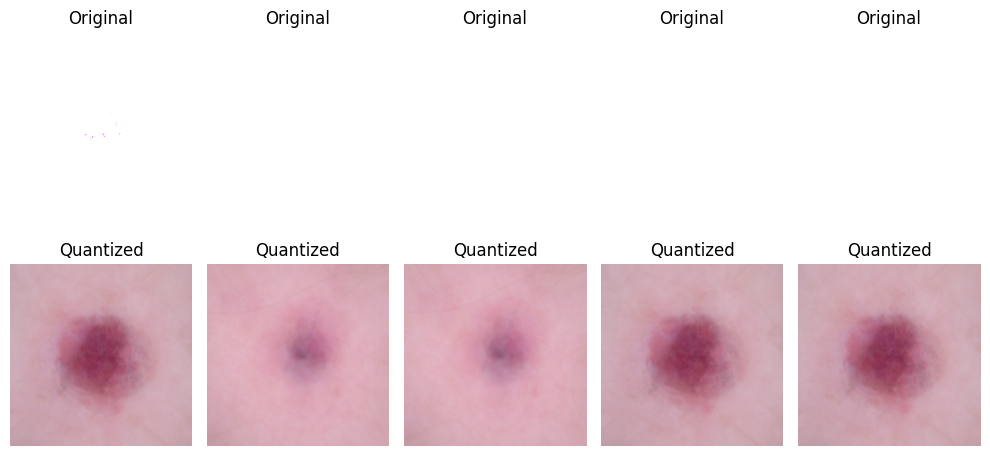

In [37]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to resize and flatten the images
def preprocess_images(images, target_size=(256, 256)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img.flatten())
    return np.array(resized_images)

# Function to apply K-means clustering and return quantized images
def apply_kmeans(images, num_clusters=8):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(images)
    quantized_images = kmeans.cluster_centers_[kmeans.labels_]
    quantized_images = quantized_images.reshape(images.shape[0], *target_size, 3)
    return quantized_images

# Load your dataset and preprocess it
# Assuming you have your images loaded into a variable named 'images'
# And you have labels stored in a variable named 'labels'

# Preprocess the images
target_size = (256, 256)
processed_images = preprocess_images(images, target_size=target_size)

# Apply K-means clustering
num_clusters = 7
quantized_images = apply_kmeans(processed_images, num_clusters=num_clusters)

# Visualize the original and quantized images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(quantized_images[i].astype(np.uint8))
    plt.title('Quantized')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [40]:
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
!make



Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.35 MiB | 7.71 MiB/s, done.
Resolving deltas: 100% (10670/10670), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -c ./src/image_opencv.cpp -o obj/image_opencv.o
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -c ./src/http_stream.cpp -o obj/http_stream.o
./src/http_stream.cpp: In member function ‘bool JSON_sender::write(const char*)’:
./src/http_stream.cpp:253:21: warning: unused variable ‘n’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-variable-Wunused-variable]8;;]
  253 |                 int n = _writ

ERROR: Invalid requirement: './darknet'
Hint: It looks like a path. The path does exist. 
